## Model following KK10

NB: Vmin has an impact on L. See how I handle this. One idea would be to use storm_speed as an ersatz for Vmin (if storm_speed increases, then Vmin increases and thus L increases).

Other idea: L becomes a hyperparameter that we tune like lambda

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import functions_BL as BL
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# PATHS = {
#     'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#     'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
#     'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
# }

In [3]:
PRMS = {
    'vmin':  4,                           # minimum wind speed for Holland profile fitting [m/s]
    'rs':    np.linspace(10, 5e5, 50000), # ref. grid [m] - take a lot of points to compute vorticity properly
    'dt':    6 * 3600,                    # timestep [s]
    'dilat': True,
}

In [4]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def charac_length(V):
    '''Given a wind profile object V, returns its characteristic length L'''
    rel_vort = vorticity(V.rad, V.ws)
    abs_vort = coriolis(V.lat)
    q        = (V.rad * V.ws ** 2) / (rel_vort + abs_vort)
    return V.rad[np.nanargmax(q)]

def get_scales(V, show=False):
    # Fit Holland
    vmx, rmx, B = fit_h80(V)
    # Compute L on Vh relative (vmin = 0)
    Vh_rel = xr.Dataset(
        data_vars={
            'ws': ('rad', h80(V.rad, vmx, rmx, B, V.lat, 0).data),
            'lat': V.lat.data,
            'time': V.time.data,
        },
        coords={
            'rad': V.rad.data
        }
    )
    # Compute scales
    L      = charac_length(Vh_rel) # Vmin must be 0
    U_star = coriolis(Vh_rel.lat) * rmx
    
    if show:
        print('B  = {:.1f}'.format(B))
        print('L  = {:.0f} km'.format(L / 1000))
        print('U* =  {:.1f} m/s'.format(U_star))
        print('T  = {:.1f} h'.format(L / U_star / 3600))        
    return L, U_star
    
def nb_of_timesteps(L, U_star, delta_t, show=False):
    nt = delta_t / (L / U_star)
    if show:
        print('nb of t-stps: {:.2f}'.format(nt))
    return nt

def non_dimensional(V, L):
    V_nd = xr.DataArray(
        data=V.ws / (coriolis(V.lat) * L),
        coords={'rad': V.rad / L}
    )
    return V_nd

# def dimensional(ws, V, L):
#     V_nd = xr.DataArray(
#         data=ws * coriolis(V.lat) * L,
#         coords={'rad': V.rad}
#     )
#     return V_nd

def h80(r, vm, rm, B, lat, vmin=PRMS['vmin']):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_h80(V):
    '''Given an xr.Dataset V of wind speed 'ws' with 'rad' as dim & coord (m) and 'lat' as second variable,
    returns the parameters of fitted Holland 1980 profile.
    CAVEAT: coordinate 'rad' must be > 0, else the residuals are not finite for r = 0.
    '''
    popt, pcov = curve_fit(
        f=lambda r, vm, rm, B: h80(r, vm, rm, B, V.lat, vmin=PRMS['vmin']),
        xdata=V.rad,
        ydata=V['ws'],
        p0=[V['ws'].max(), V.rad[V['ws'].argmax()], 1.5],
        bounds=[
            (V['ws'].max() * 0.5, V.rad[V['ws'].argmax()] * 0.5, 0.5,),
            (V['ws'].max() * 1.5, V.rad[V['ws'].argmax()] * 1.5, 5,)
        ]
    )
    return popt # Vmax, Rmax, B

# def fit_h80(V):
#     '''Given an xr.Dataset V of wind speed 'ws' with 'rad' as dim & coord (m) and 'lat' as second variable,
#     returns the parameters of fitted Holland 1980 profile.
#     CAVEAT: coordinate 'rad' must be > 0, else the residuals are not finite for r = 0.
#     '''
#     popt, pcov = curve_fit(
#         f=lambda r, vm, rm, B, vmin: h80(r, vm, rm, B, V.lat, vmin),
#         xdata=V.rad,
#         ydata=V['ws'],
#         p0=[V['ws'].max(), V.rad[V['ws'].argmax()], 1.5, V['ws'].min()],
#         bounds=[
#             (V['ws'].max() * 0.5, V.rad[V['ws'].argmax()] * 0.5, 0.5, V['ws'].min() * 0.5),
#             (V['ws'].max() * 1.5, V.rad[V['ws'].argmax()] * 1.5, 5,   V['ws'].min() * 1.5)
#         ]
#     )
#     return popt # Vmax, Rmax, B, Vmin

def v_kk11(v0, t, lbda):
    '''Given an initial wind profile v0, propagates according to KK11 and using lambda'''
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def V_KK11(Vi, L, nt, lbda):
    '''Make wind profile non-dimensional, then perform v_kk11(), then go back to dimensional wind profile'''
    # Non-dimensionalization
    Vi_nd = non_dimensional(Vi, L)
    # Get Kalashnik wind
    Vk_nd = xr.DataArray(
        data=v_kk11(Vi_nd, nt, lbda),
        coords={'rad': Vi_nd.rad}
    )
    # Dimensionalize
    Vk_d  = xr.DataArray(
        data=Vk_nd * coriolis(Vi.lat) * L,
        coords={'rad': Vi.rad}
    )
    # Formatting
    Vf = xr.Dataset(
        data_vars={
            'ws':          ('rad', Vk_d.data),
            'lat':         Vi.lat.data + 5 * PRMS['dt'] * np.cos(np.pi / 4) / 110000, # assume TC goes at 5 m/s, with an angle 45° from North, and 1°N is 110 km
            # 'storm_speed': dss.storm_speed_IBT.data,
            'time':        Vi.time.data + np.timedelta64(PRMS['dt'],'s'),
        },
        coords={
            'rad': Vi.rad.data
        }
    )
    # Fill end of profile with last value (to avoid NaNs, otherwise curve_fit doesn't work)
    Vf['ws'] = Vf.ws.fillna(Vf.ws[Vf.ws.notnull()][-1])
    return Vf

def R17(V):
    ws_out = V.isel(rad=slice(int(V.ws.argmax()), None)).ws
    return ws_out.where(ws_out < 17.5, drop=True).isel(rad=0).rad

# def dilat_factor(V, alpha=(1 / 35)):
#     r17  = R17(V)
#     fcor = coriolis(V.lat)
#     return alpha * (fcor * r17)

# def dilat(V, alpha):
#     V_dilat        = V.copy(deep=True)
#     V_dilat['rad'] = V_dilat['rad'] * (1 + dilat_factor(V_dilat, alpha)) 
#     V_dilat        = V_dilat.interp({'rad': PRMS['rs']})
#     # Fill beginning of profile with first value (to avoid NaNs, otherwise curve_fit doesn't work)
#     V_dilat['ws']  = V_dilat.ws.fillna(V_dilat.ws[V_dilat.ws.notnull()][0])
#     return V_dilat

def dilat_v2(V, alpha):
    V_dilat        = V.copy(deep=True)
    V_dilat['rad'] = V_dilat['rad'] * (1 + alpha) 
    V_dilat        = V_dilat.interp({'rad': PRMS['rs']})
    # Fill beginning of profile with first value (to avoid NaNs, otherwise curve_fit doesn't work)
    V_dilat['ws']  = V_dilat.ws.fillna(V_dilat.ws[V_dilat.ws.notnull()][0])
    return V_dilat

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


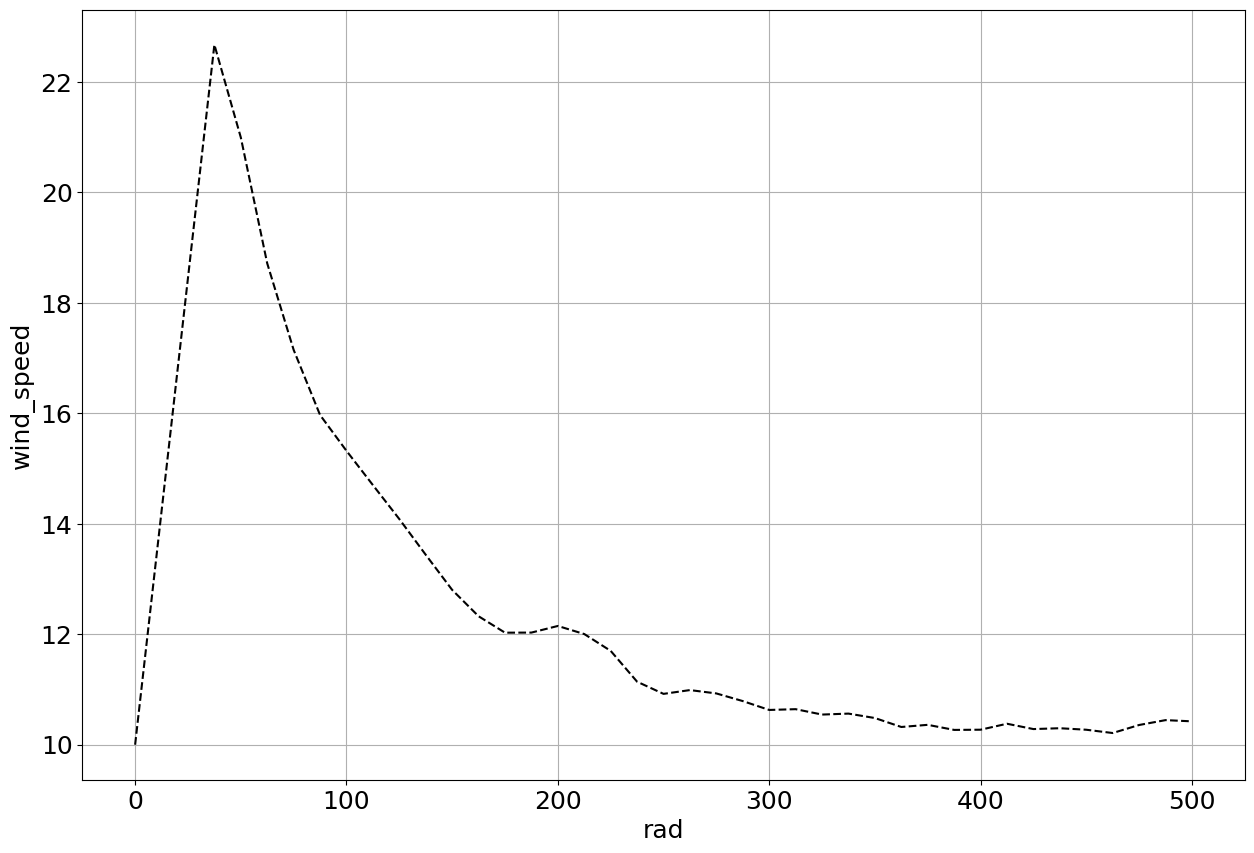

In [5]:
p   = '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered/POLAR/2020/EP182020/POL_ascat_20201001_044800_metopb_41705_srv_o_125_ovw.nc'
dss = xr.open_dataset(p)

# Custom initialization
def affine(vmax, vmin, rmax, r):
    return ((vmax - vmin) / (rmax - 0)) * r + vmin

V_ini        = dss.wind_speed.mean(dim='theta', skipna=True)
V_ini[0]     = 10
V_ini[1]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=1 * 12.5)
V_ini[2]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=2 * 12.5)
V_ini.plot(c='k', linestyle='--', label='custom total');plt.grid()
V_ini['rad'] = V_ini.rad * 1000
V_ini        = V_ini.interp({'rad': PRMS['rs']})

# # Create the structure
# Vi = xr.Dataset(
#     data_vars={
#         'ws':          ('rad', V_ini.data),
#         'lat':         dss.lat_IBT.data,
#         # 'storm_speed': dss.storm_speed_IBT.data,
#         'time':        dss.acquisition_time.data,
#     },
#     coords={
#         'rad': PRMS['rs']
#     }
# )

# Create the structure
Vi = xr.Dataset(
    data_vars={
        'ws':          ('rad', h80(PRMS['rs'], 13, 37000, 1.9, dss.lat_IBT.data, vmin=10).data),
        'lat':         dss.lat_IBT.data,
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        dss.acquisition_time.data,
    },
    coords={
        'rad': PRMS['rs']
    }
)

In [6]:
### MODEL
def MODEL(V, lbda, alpha, show=False):
    L, U_star = get_scales(V, show)
    
    
    # # L = 150000
    # print(R17(V))
    L = R17(V) * 1.5
    
    
    nt = nb_of_timesteps(L, U_star, PRMS['dt'], show)
    # Apply KK11 model
    Vf = V_KK11(V, L, nt, lbda)
    # Dilatation
    Vf = dilat_v2(Vf, alpha)
    return Vf

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

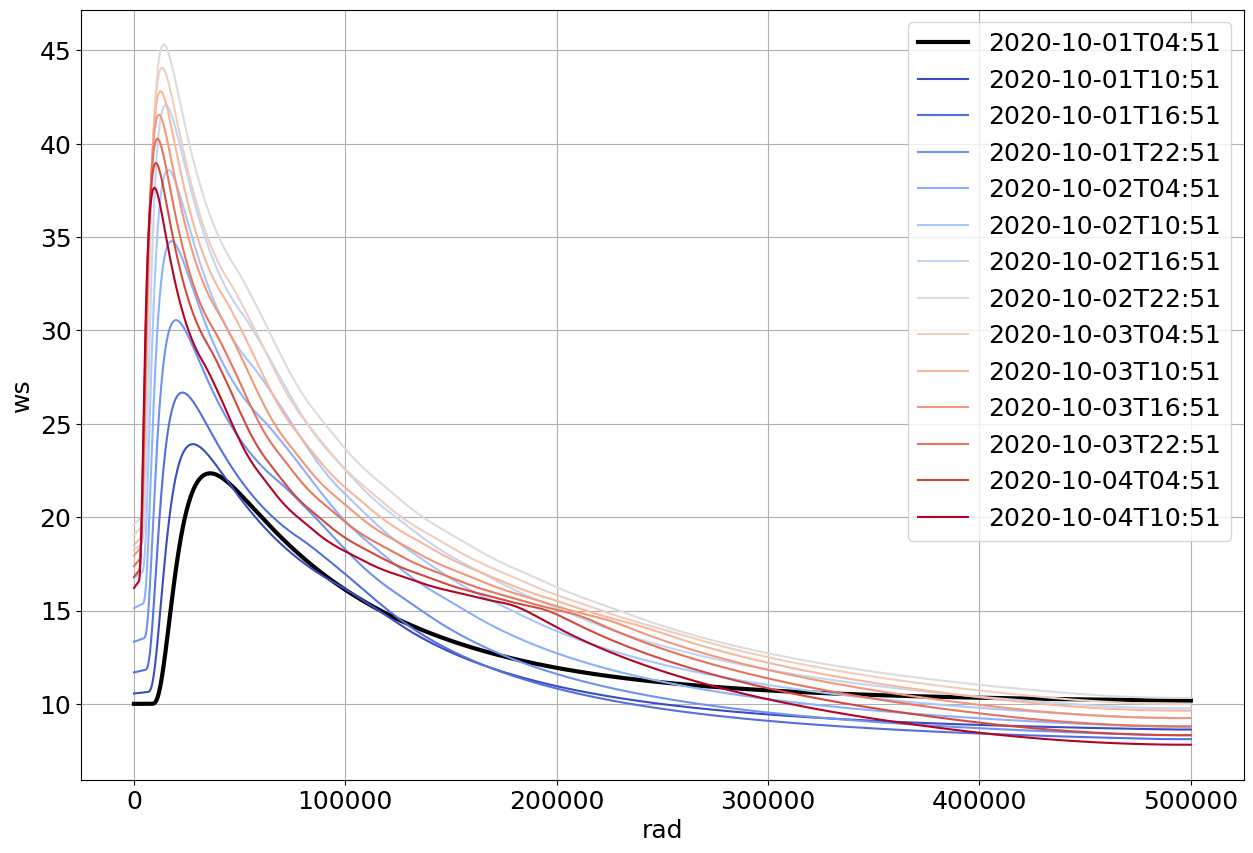

In [7]:
### EXECUTE MODEL
# lbds  = [0.3, 0.2, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5]
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
# lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 0.9, 0.9, 0.9, 0.9]
alphas = list(np.sqrt(np.linspace(0, len(lbds), len(lbds))) / 8)
# alphas[0] = alphas[1] = alphas[2] = alphas[3] = alphas[4] = alphas[5] = alphas[6] = 0
alphas = list(np.zeros_like(lbds))
print(alphas)

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V = MODEL(Vi, l, a, show=False)
    else:
        V = MODEL(V, l, a, show=False)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()

In [8]:
# rel_vort = vorticity(V.rad, V.ws)
# abs_vort = coriolis(V.lat)
# q        = (V.rad * V.ws ** 2) / (rel_vort + abs_vort)

In [9]:
# vorticity(Vi.isel(rad=slice(2000, None)).rad, (Vi - 10).isel(rad=slice(2000, None)).ws).plot()
# plt.grid()

#### Test with a Boundary Layer

In [10]:
Cd = 2e-3
K  = 50

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

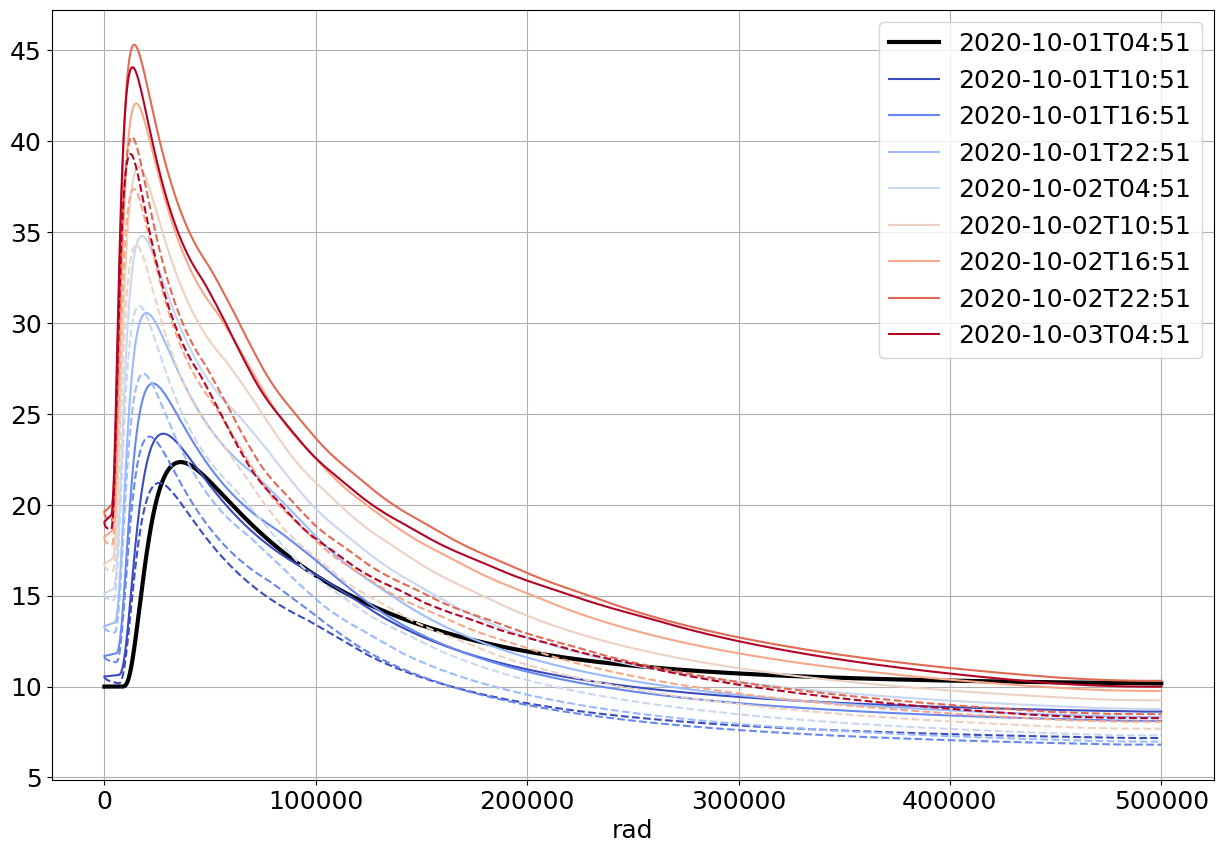

In [11]:
### EXECUTE MODEL
# lbds  = [0.3, 0.2, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5]
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5]
# lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 0.9, 0.9, 0.9, 0.9]
alphas = list(np.sqrt(np.linspace(0, len(lbds), len(lbds))) / 8)
# alphas[0] = alphas[1] = alphas[2] = alphas[3] = alphas[4] = alphas[5] = alphas[6] = 0
alphas = list(np.zeros_like(lbds))
print(alphas)

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V    = MODEL(Vi, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
    else:
        V    = MODEL(V, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    v_BL.plot(c=colors[i], linestyle='--')
    
plt.grid()
plt.legend()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

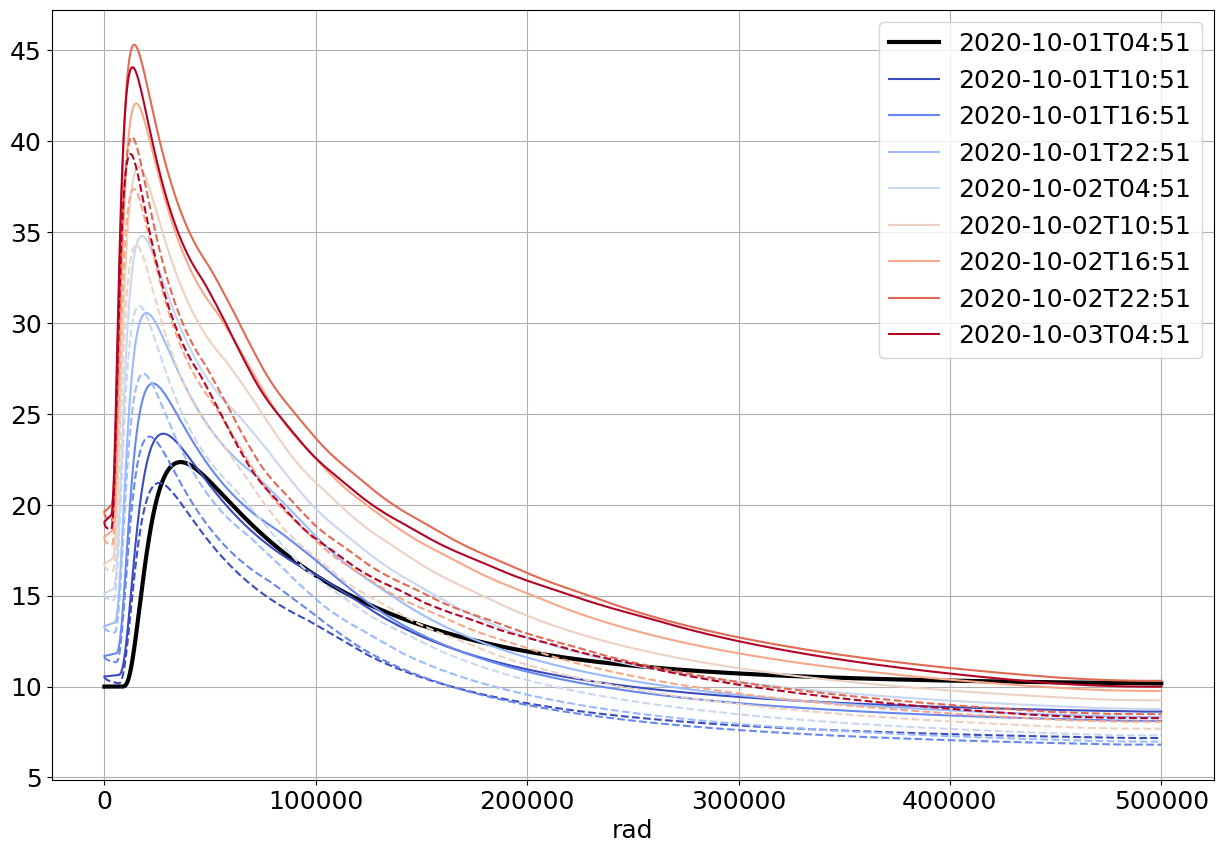

In [12]:
### EXECUTE MODEL
# lbds  = [0.3, 0.2, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5]
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5]
# lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 0.9, 0.9, 0.9, 0.9]
alphas = list(np.sqrt(np.linspace(0, len(lbds), len(lbds))) / 8)
# alphas[0] = alphas[1] = alphas[2] = alphas[3] = alphas[4] = alphas[5] = alphas[6] = 0
alphas = list(np.zeros_like(lbds))
print(alphas)

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V    = MODEL(Vi, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
    else:
        V    = MODEL(V, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    v_BL.plot(c=colors[i], linestyle='--')
    
plt.grid()
plt.legend()

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

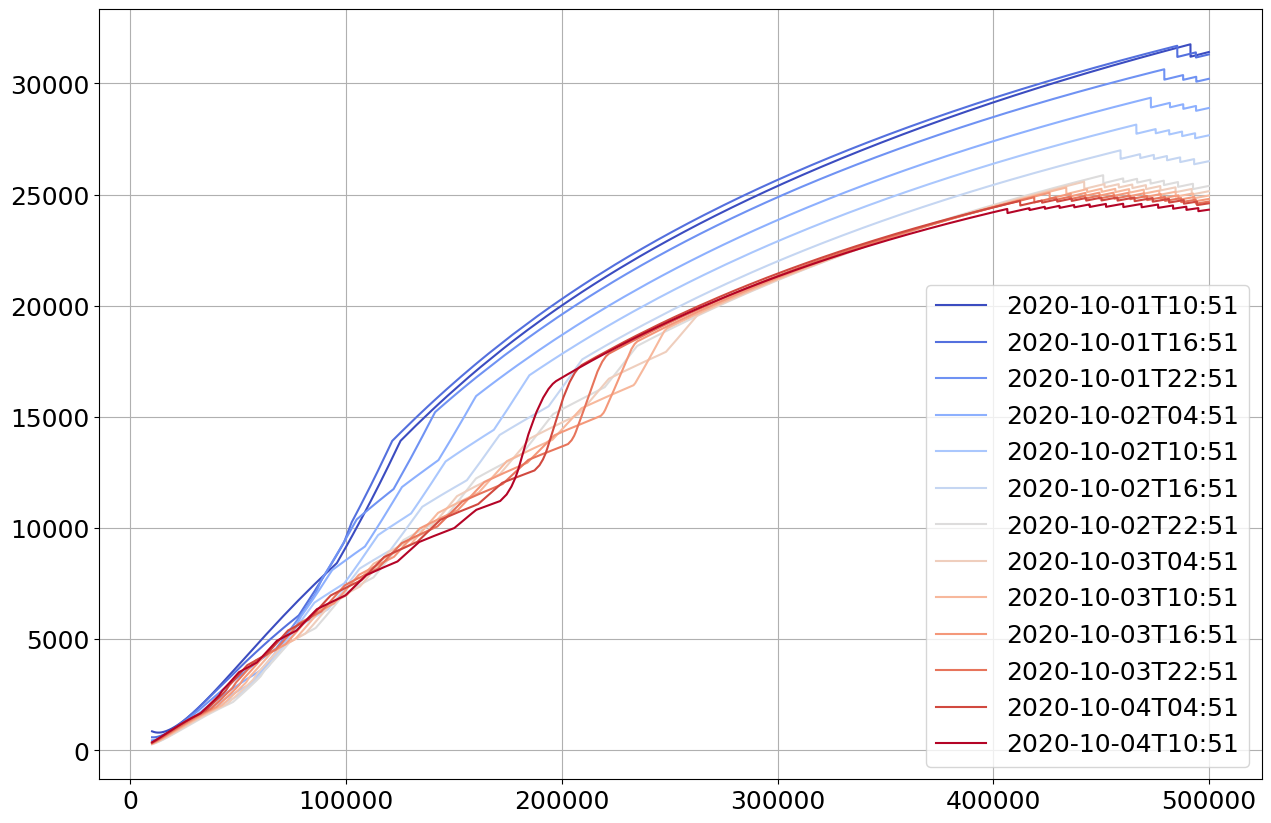

In [13]:
# CHARACTERISTIC TIME
# lbds  = [0.3, 0.2, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5]
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.]
# lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5, 0.9, 0.9, 0.9, 0.9]
alphas = list(np.sqrt(np.linspace(0, len(lbds), len(lbds))) / 8)
# alphas[0] = alphas[1] = alphas[2] = alphas[3] = alphas[4] = alphas[5] = alphas[6] = 0
alphas = list(np.zeros_like(lbds))

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V    = MODEL(Vi, l, a, show=False)
    else:
        V    = MODEL(V, l, a, show=False)
        
    # Plot
    plt.plot(PRMS['rs'][1000:], (2 / BL.I(PRMS['rs'], V.ws, coriolis(V.lat)))[1000:], label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()

### Weakening phase

nb of scat files =  57


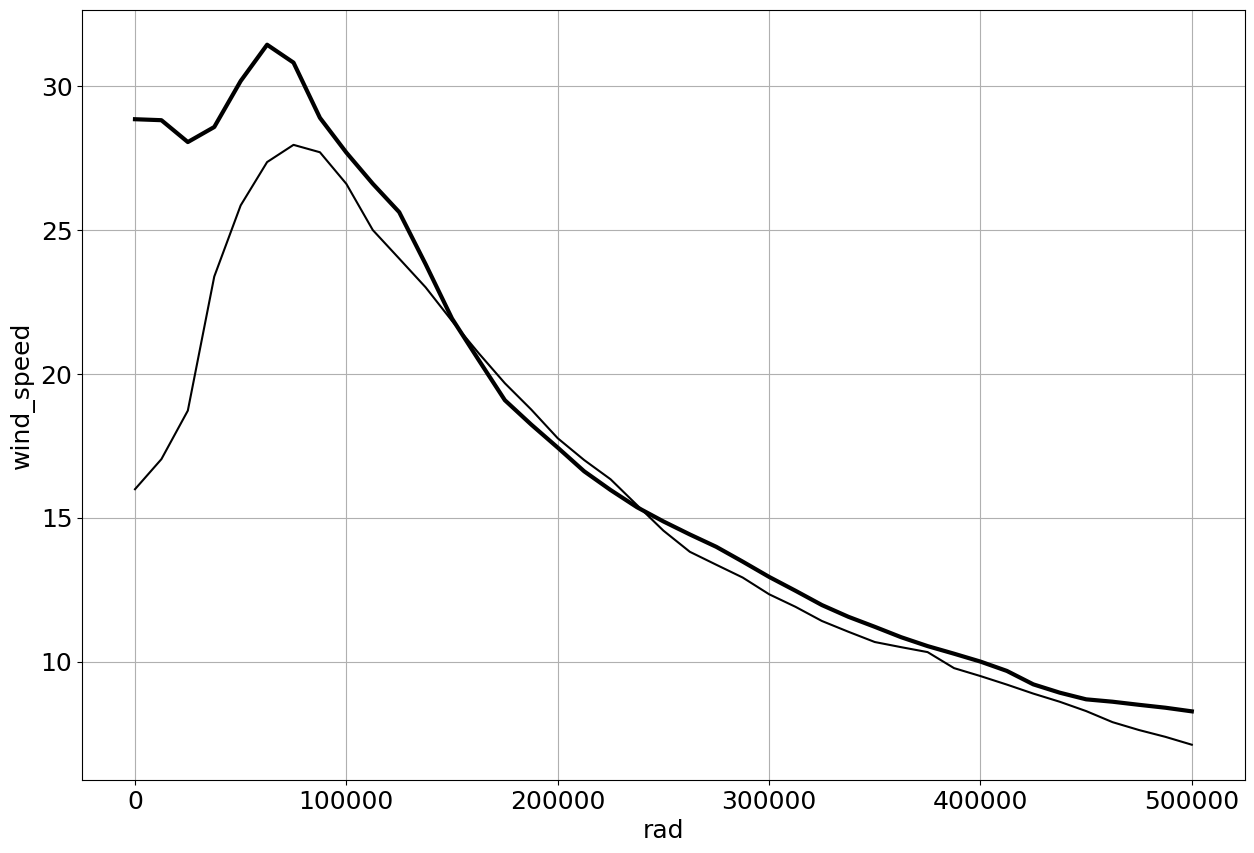

In [14]:
### WEAKENING PHASE

def path2datetime(path):
    '''
    Given a path like: '/home/arthur/data/scatterometer/KNMI/metop_c/ascat/2019/025/ascat_20190125_144500_metopc_01131_srv_o_125_ovw.nc'
    returns the datetime object corresponding to acquisition start time: datetime.datetime(2019, 1, 25, 14, 45)
    '''
    dt_as_list = re.split(r'(\d+)', os.path.basename(path))[1:4] # ['20150403', '_', '071800']
    dt_conc    = ''.join(dt_as_list)                             # '20150403T071800'
    return datetime.strptime(dt_conc, "%Y%m%d_%H%M%S")

### OPEN DATA
all_sct = glob.glob('/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered/POLAR/2020/EP182020/' + '*.nc')
print('nb of scat files = ', len(all_sct))

# Sort all files
all_sct = sorted(all_sct, key=path2datetime)
# Custom list
all_sct = all_sct[22:]

ds1        = xr.open_dataset(all_sct[16])
ds2        = xr.open_dataset(all_sct[20])
ds1['rad'] = ds1.rad * 1000
ds2['rad'] = ds2.rad * 1000
v1         = ds1.wind_speed.mean(dim='theta', skipna=True)
v2         = ds2.wind_speed.mean(dim='theta', skipna=True)
v1.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[16])), unit='m')), c='k', linewidth=3)
v2.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[20])), unit='m')), c='k')
plt.grid()

In [15]:
fRm1 = coriolis(ds1.lat_IBT) * v1.idxmax()
fRm2 = coriolis(ds2.lat_IBT) * v2.idxmax()

print('Vm1 = {:.1f} m/s'.format(v1.max()))
print('Vm2 = {:.1f} m/s'.format(v2.max()))

print('f1 * Rm1 = {:.1f} m/s'.format(fRm1))
print('f2 * Rm2 = {:.1f} m/s'.format(fRm2))

# Graphically 10 m/s <--> 2 f * Rm in this area
# So 3 m/s is ~ 0.6 f * Rm

Vm1 = 31.4 m/s
Vm2 = 28.0 m/s
f1 * Rm1 = 3.1 m/s
f2 * Rm2 = 3.8 m/s


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

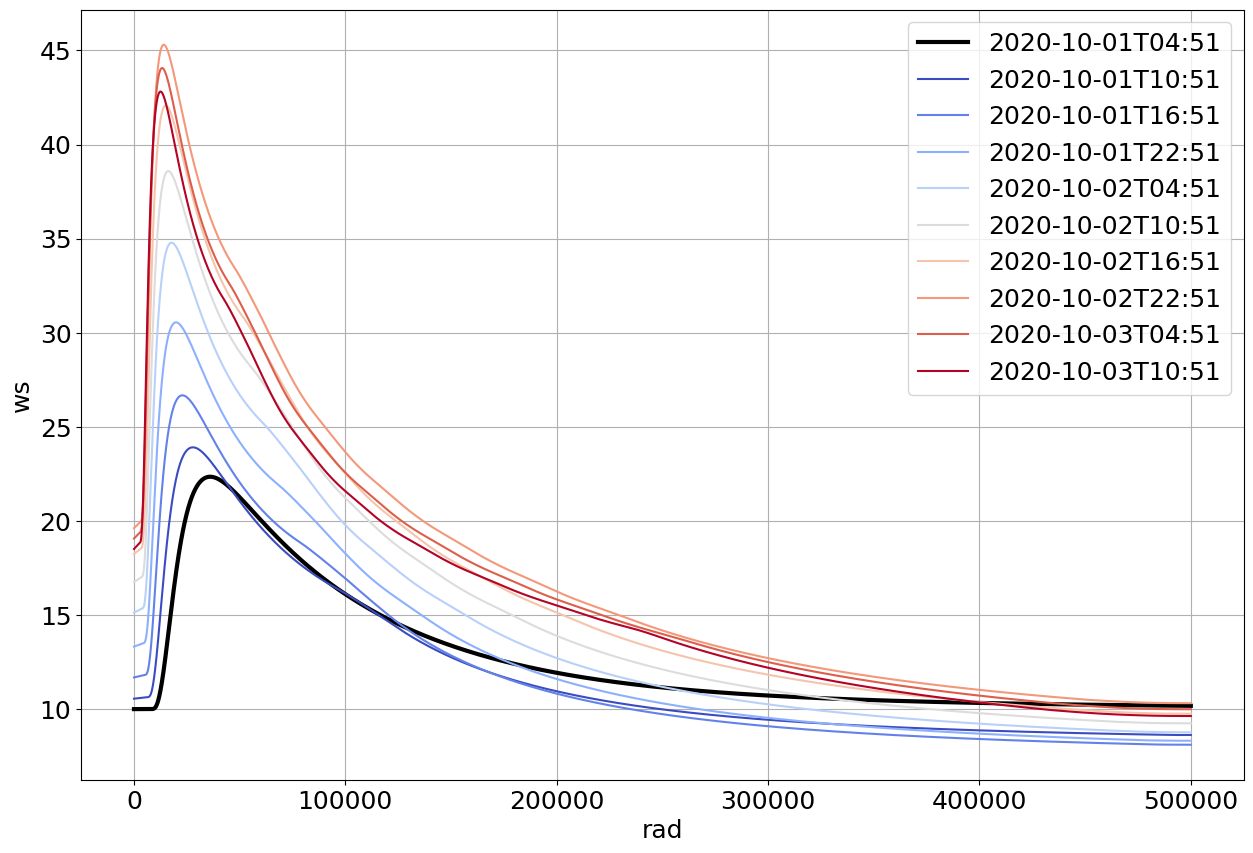

In [16]:
### EXECUTE MODEL
lbds  = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5]
alphas = list(np.zeros_like(lbds)) # No dilatation

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V = MODEL(Vi, l, a, show=False)
    else:
        V = MODEL(V, l, a, show=False)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()

Vm  = 42.8 m/s
Vm2 = 32.1 m/s
Rm = 12.6 km
Rm2 = 12.6 km


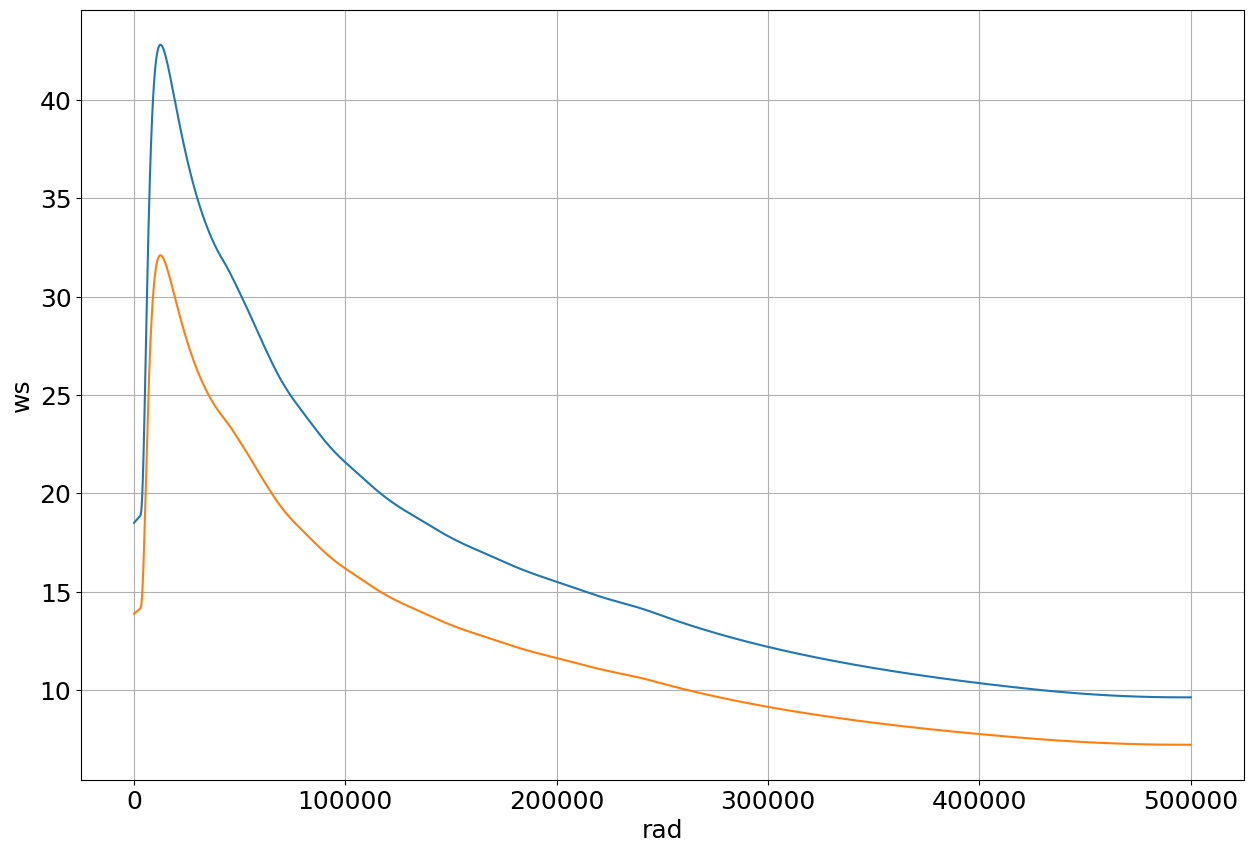

In [17]:
V2 = V.copy(deep=True)
V2['ws'] = V2.ws * 0.75

V.ws.plot()
V2.ws.plot()
plt.grid()

print('Vm  = {:.1f} m/s'.format(V.ws.max()))
print('Vm2 = {:.1f} m/s'.format(V2.ws.max()))

print('Rm = {:.1f} km'.format(V.ws.idxmax() / 1000))
print('Rm2 = {:.1f} km'.format(V2.ws.idxmax() / 1000))

fRm1 = 0.6 m/s
Rm2 computed = 50.3 km
dilat factor = 4.00


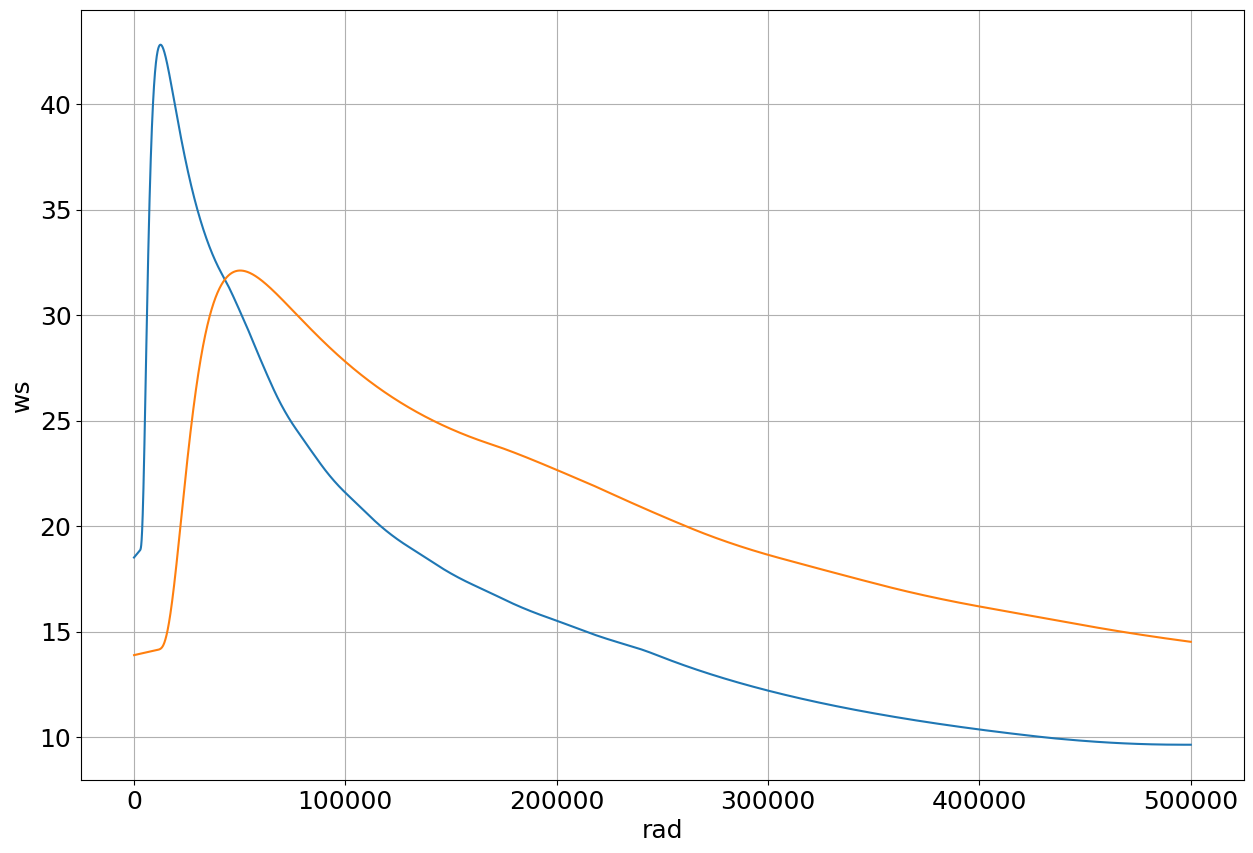

In [18]:
fRm1 = coriolis(20) * V.ws.idxmax()
print('fRm1 = {:.1f} m/s'.format(fRm1))

Rm2 = (fRm1 + 2) /  coriolis(21)
print('Rm2 computed = {:.1f} km'.format(Rm2 / 1000))

alpha = Rm2 / V.ws.idxmax()
print('dilat factor = {:.2f}'.format(alpha))

V2['rad'] = V2.rad * alpha
V2 = V2.interp({'rad': PRMS['rs']})

V.ws.plot()
V2.ws.plot()
plt.grid()

Vm  = 42.8 m/s
Vm2 = 22.7 m/s
Rm = 12.6 km
Rm2 = 12.6 km


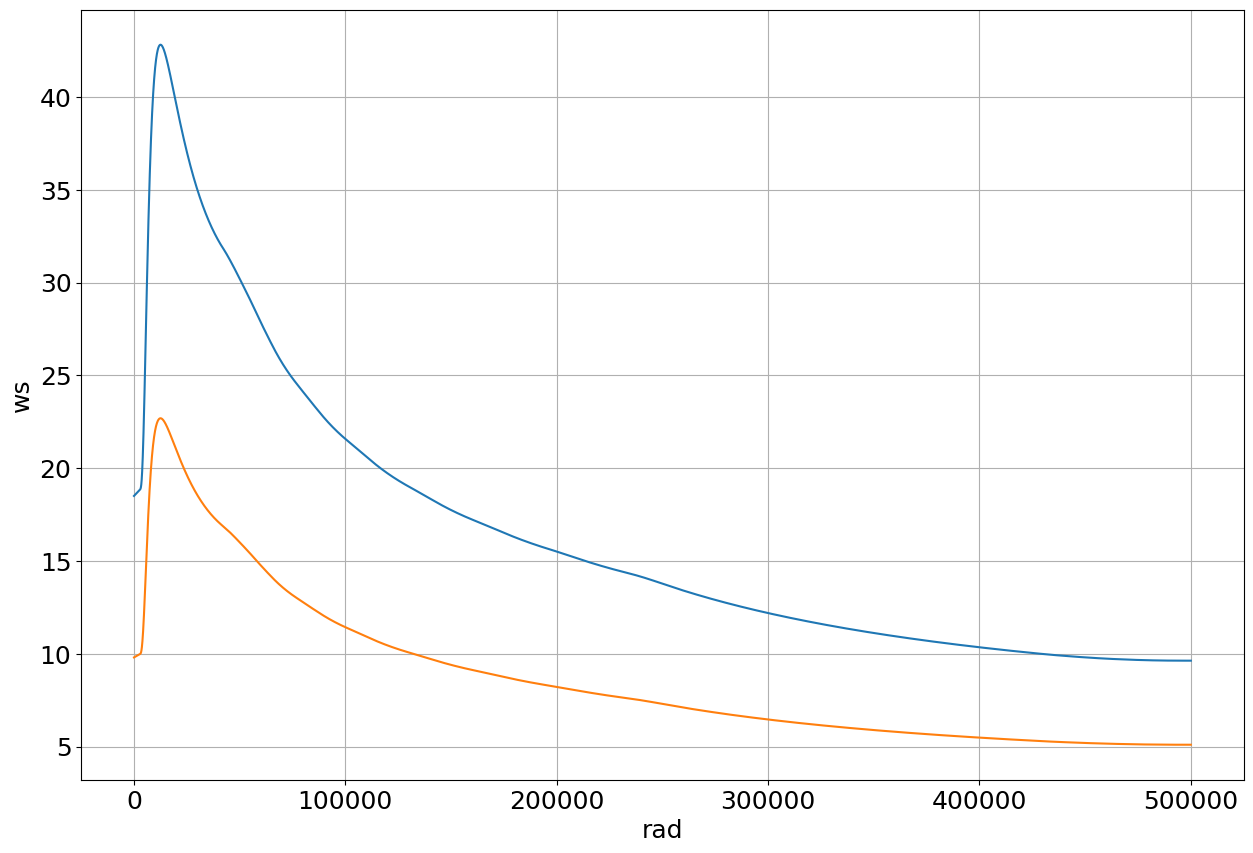

In [19]:
V2 = V.copy(deep=True)
V2['ws'] = V2.ws * 0.53

V.ws.plot()
V2.ws.plot()
plt.grid()

print('Vm  = {:.1f} m/s'.format(V.ws.max()))
print('Vm2 = {:.1f} m/s'.format(V2.ws.max()))

print('Rm = {:.1f} km'.format(V.ws.idxmax() / 1000))
print('Rm2 = {:.1f} km'.format(V2.ws.idxmax() / 1000))

fRm1 = 0.6 m/s
Rm2 computed = 81.2 km
dilat factor = 6.46


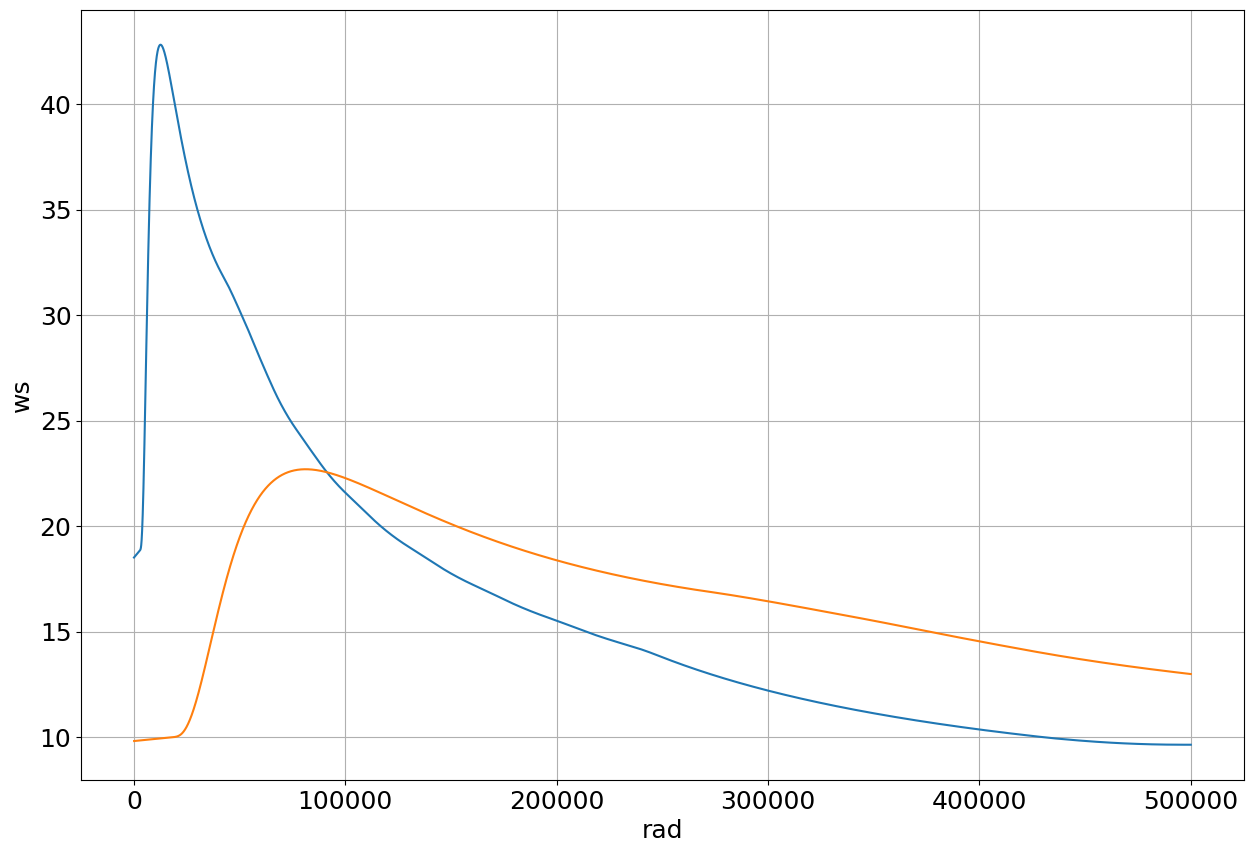

In [20]:
fRm1 = coriolis(20) * V.ws.idxmax()
print('fRm1 = {:.1f} m/s'.format(fRm1))

Rm2 = (fRm1 + 2 * 2) /  coriolis(23)
print('Rm2 computed = {:.1f} km'.format(Rm2 / 1000))

alpha = Rm2 / V.ws.idxmax()
print('dilat factor = {:.2f}'.format(alpha))

V2['rad'] = V2.rad * alpha
V2 = V2.interp({'rad': PRMS['rs']})

V.ws.plot()
V2.ws.plot()
plt.grid()

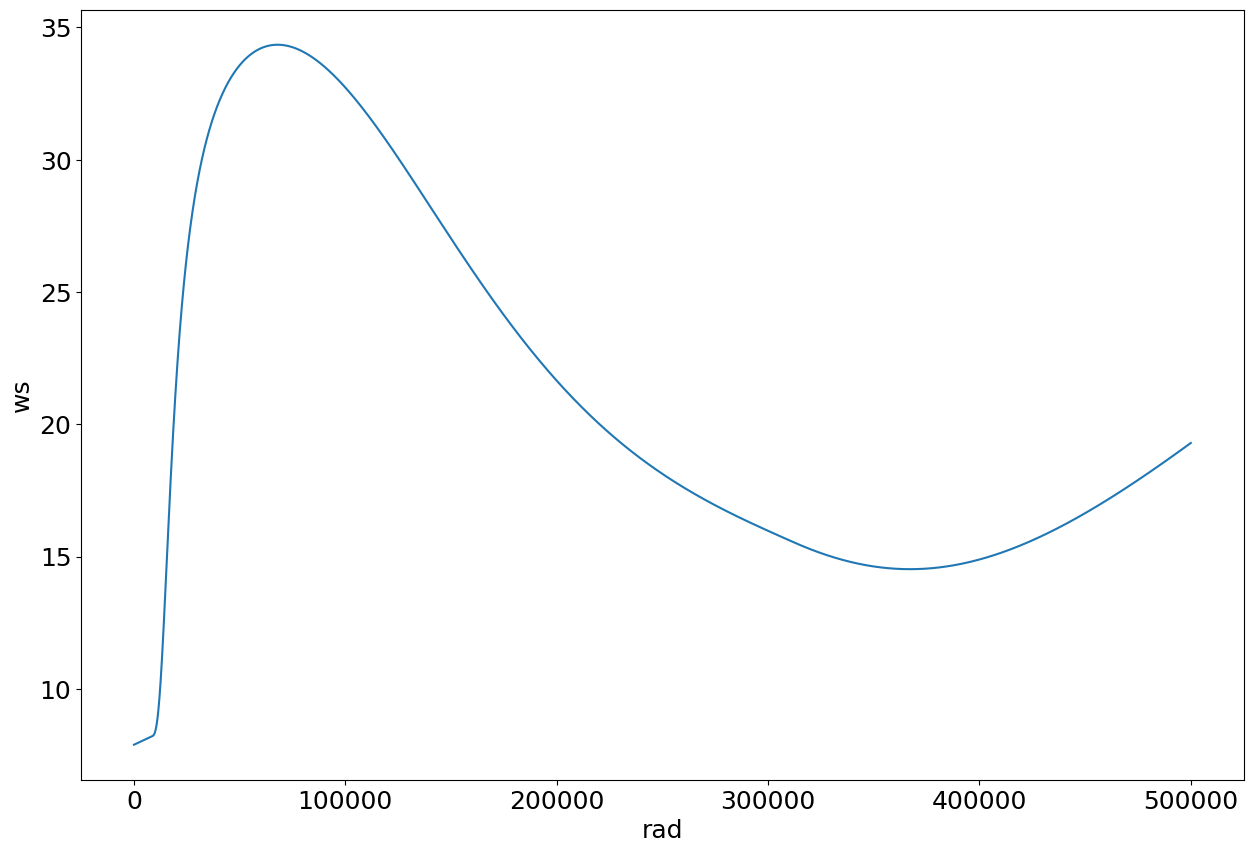

In [21]:
chi = np.linspace(np.log(0.7), np.log(2), num=len(PRMS['rs']))

Vi = xr.Dataset(
    data_vars={
        'ws':          ('rad', h80(PRMS['rs'], 50, 37000, 2, dss.lat_IBT.data, vmin=10).data),
        'lat':         dss.lat_IBT.data,
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        dss.acquisition_time.data,
    },
    coords={
        'rad': PRMS['rs']
    }
)

# for t in [1e4, 2e4, 3e4]:
#     BL.v_evolved(PRMS['rs'], Vi['ws'], coriolis(20), chi, t).plot()
# plt.grid()

Vi['ws'] = BL.v_evolved(PRMS['rs'], Vi['ws'], coriolis(20), chi, 3e4)

Vi.ws.plot()

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


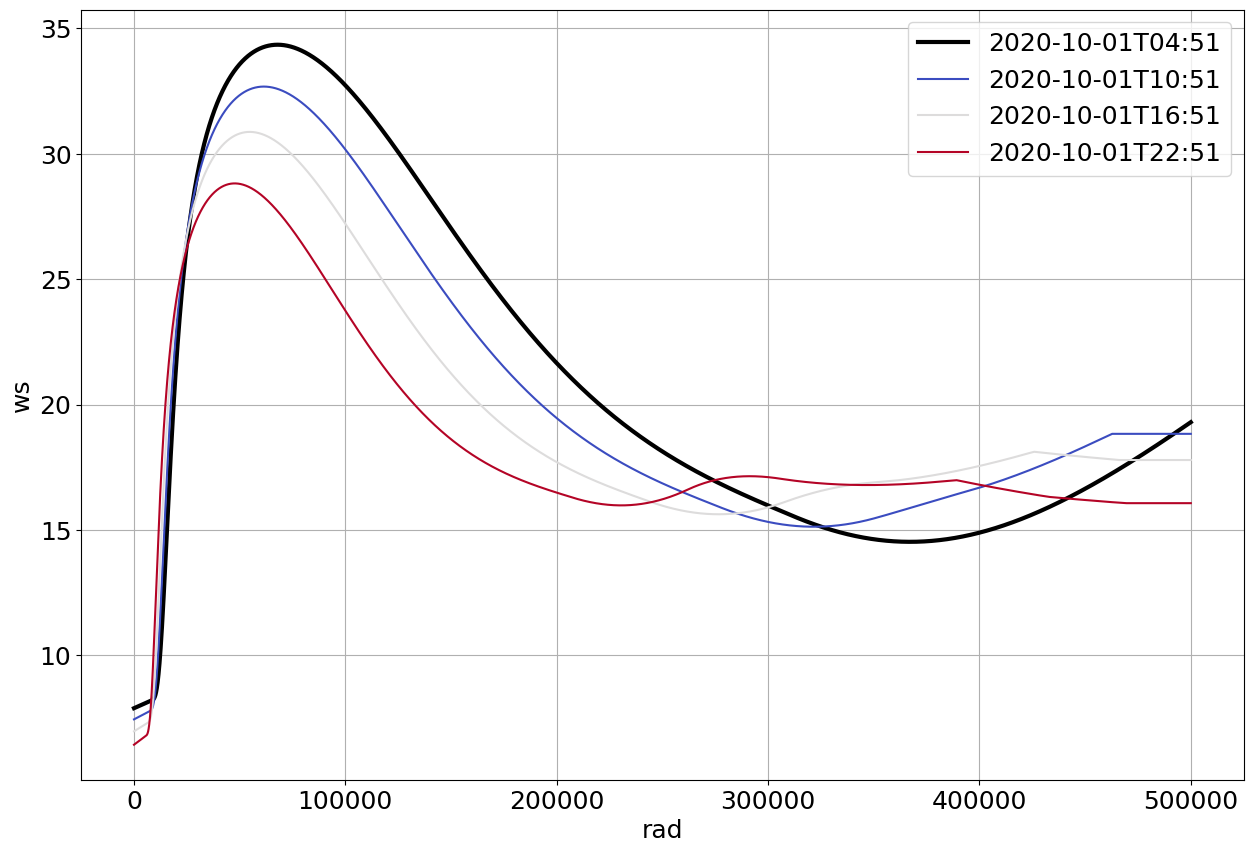

In [22]:
### EXECUTE MODEL
lbds   = [1.5, 1.5, 1.5]
alphas = list(np.zeros_like(lbds))

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V    = MODEL(Vi, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
    else:
        V    = MODEL(V, l, a, show=False)
        v_BL = V.ws + BL.v_prime(PRMS['rs'], V.ws, coriolis(V.lat), Cd, K)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()

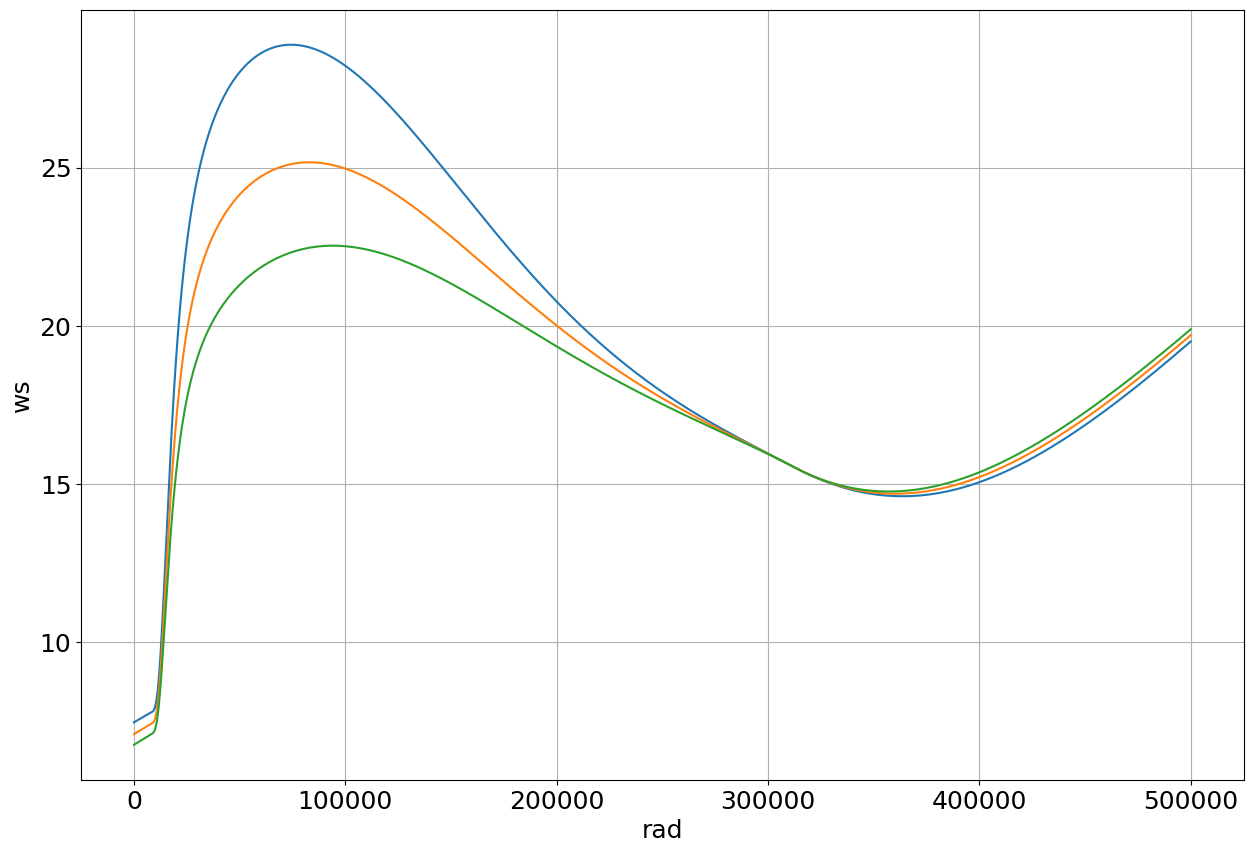

In [23]:
for t in [1e5, 2e5, 3e5]:
    BL.v_evolved(PRMS['rs'], Vi['ws'], coriolis(20), 0.1, t).plot()
plt.grid()

### TEST with varying lambda

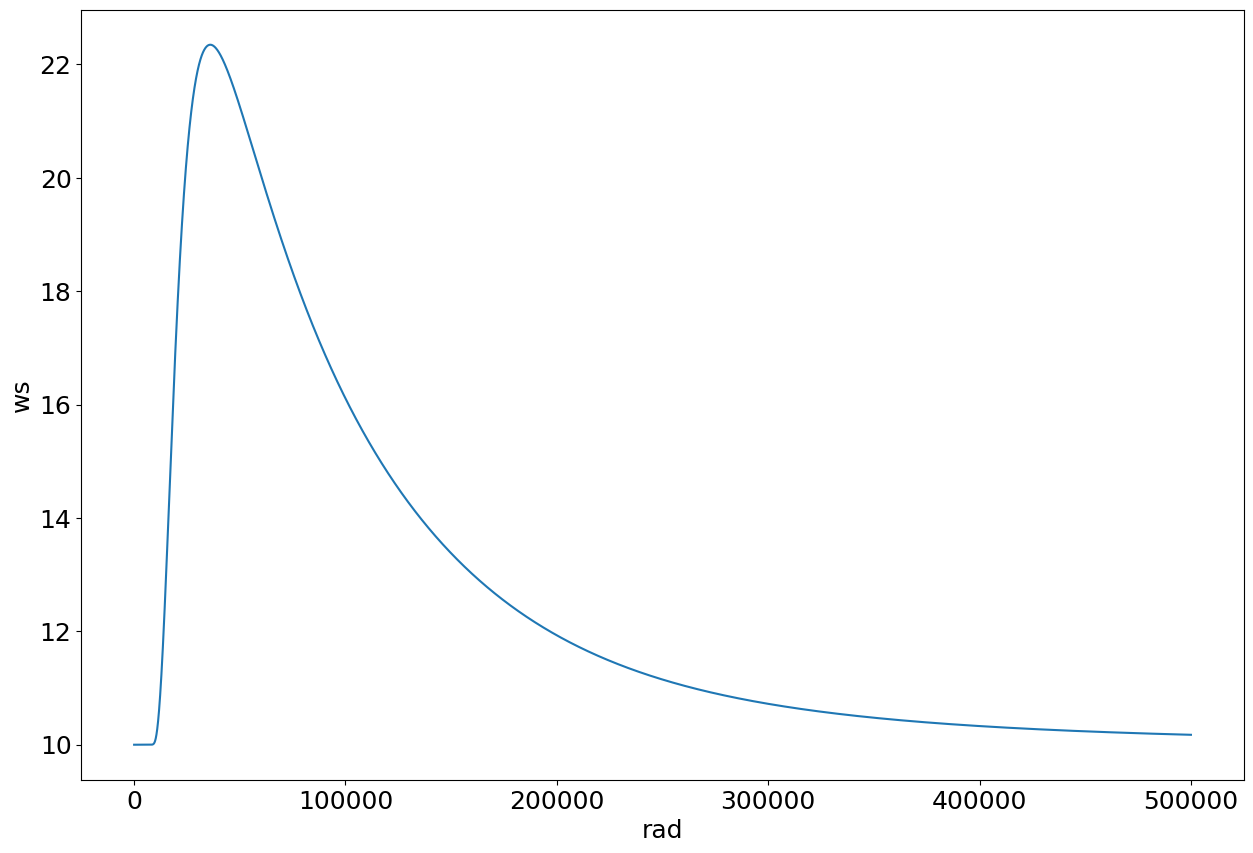

In [43]:
# Initialize
Vi = xr.Dataset(
    data_vars={
        'ws':          ('rad', h80(PRMS['rs'], 13, 37000, 1.9, dss.lat_IBT.data, vmin=10).data),
        'lat':         dss.lat_IBT.data,
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        dss.acquisition_time.data,
    },
    coords={
        'rad': PRMS['rs']
    }
)
Vi.ws.plot()

In [139]:
def v_kk11(v0, t, lbda):
    '''Given an initial wind profile v0, propagates according to KK11 and using lambda'''
    # v          = np.zeros_like(v0.rad)
    
    
    ### MODIFICATION FOR VARYING LAMBDA
    v           = xr.zeros_like(v0)
    lbda['rad'] = v0['rad'].copy(deep=True)
    ###
    

    
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = float(np.exp(-t))
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def V_KK11(Vi, L, nt, lbda):
    '''Make wind profile non-dimensional, then perform v_kk11(), then go back to dimensional wind profile'''
    # Non-dimensionalization
    Vi_nd = non_dimensional(Vi, L)
    
    
    
    ### MODIFICATION FOR VARYING LAMBDA
    da_lbda = xr.DataArray(
        data=LBDA,
        coords={'rad': Vi.rad}
    )
    ###
    
    
    
    # Get Kalashnik wind
    Vk_nd = xr.DataArray(
        data=v_kk11(Vi_nd, nt, da_lbda),
        coords={'rad': Vi_nd.rad}
    )
    # Dimensionalize
    Vk_d  = xr.DataArray(
        data=Vk_nd * coriolis(Vi.lat) * L,
        coords={'rad': Vi.rad}
    )
    # Formatting
    Vf = xr.Dataset(
        data_vars={
            'ws':          ('rad', Vk_d.data),
            'lat':         Vi.lat.data + 5 * PRMS['dt'] * np.cos(np.pi / 4) / 110000, # assume TC goes at 5 m/s, with an angle 45° from North, and 1°N is 110 km
            # 'storm_speed': dss.storm_speed_IBT.data,
            'time':        Vi.time.data + np.timedelta64(PRMS['dt'],'s'),
        },
        coords={
            'rad': Vi.rad.data
        }
    )
    # Fill end of profile with last value (to avoid NaNs, otherwise curve_fit doesn't work)
    Vf['ws'] = Vf.ws.fillna(Vf.ws[Vf.ws.notnull()][-1])
    return Vf

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/

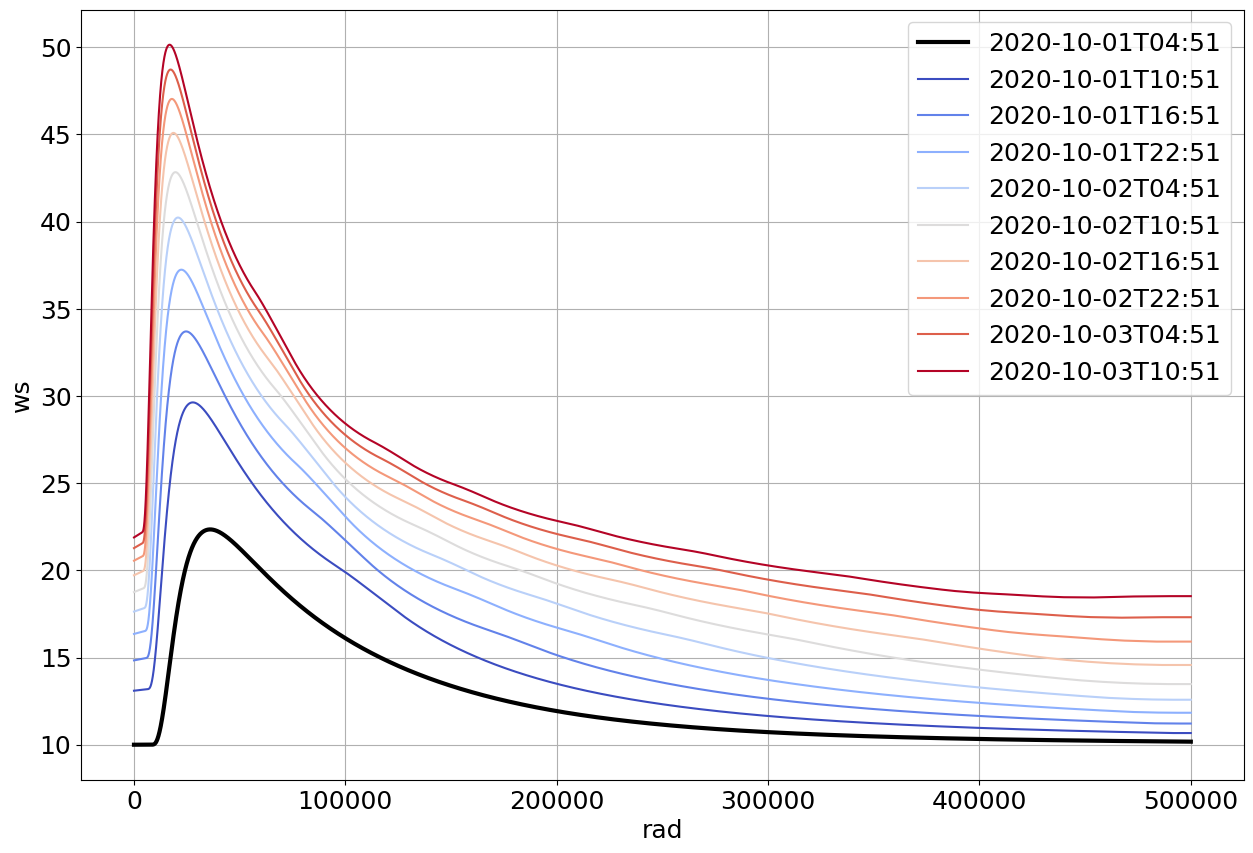

In [186]:
## Test
lbds   = [0.8, 0.5, 0.1, -0.1, -0.1, -0.1, -0.1, 1.5, 1.5]
alphas = list(np.zeros_like(lbds)) # No dilatation

# 1st option: linear lambda (lambda ~ r)
# LBDA   = (np.arange(len(PRMS['rs'])) / len(PRMS['rs']))
LBDA   = -(np.arange(len(PRMS['rs'])) / len(PRMS['rs'])) / 1000

# 2nd option: linear then inversed lambda: lambda ~ u
# LBDA = np.ones_like(PRMS['rs'])
# LBDA[:14999] = np.arange(14999) / 14999
# LBDA[14999:] = 1 / (1 + ((np.arange(50000 - 14999)) / (50000 - 14999)))
# # plt.plot(LBDA)

colors = mpl.cm.coolwarm(np.linspace(0, 1, len(lbds)))
Vi['ws'].plot(label='{}'.format(np.datetime_as_string(Vi.time, unit='m')), c='k', linewidth=3)
for i, (l, a) in enumerate(zip(lbds, alphas)):
    # Apply model
    if i == 0:
        V = MODEL(Vi, l * LBDA, a, show=False)
    else:
        V = MODEL(V, l * LBDA, a, show=False)
        
    # Plot
    V['ws'].plot(label='{}'.format(np.datetime_as_string(V.time, unit='m')), c=colors[i])
    
plt.grid()
plt.legend()